In [710]:
import os
import torch
import warnings
import pandas as pd
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

from time import time
from torch import nn
from itertools import chain
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader
from IPython.core.display_functions import clear_output

In [711]:
device = "cpu"
convert = lambda x: x if 0 < x else 0
convert = np.vectorize(convert)

In [712]:
warnings.filterwarnings("ignore")

In [713]:
if not os.path.isdir("raw_data"):
    os.chdir("../")

In [714]:
data = pd.read_excel("raw_data/Статистика_для_графиков_3_д_ТЭЦ2_УРУТ_130.xlsx")

In [715]:
data.dtypes

Дата                                                      datetime64[ns]
Выработка электроэнергии ТА гр.130                               float64
Отпуск тепла из ТО ТА гр.130                                     float64
Удельный расход условного топлива на отпуск э/э гр.130           float64
Unnamed: 4                                                       float64
Предсказание полином 2                                           float64
0.033374592702317095                                             float64
dtype: object

In [716]:
target = "Удельный расход условного топлива на отпуск э/э гр.130"

In [717]:
columns_for_predictions = [
    column
    for column in data.columns[:-1]
    if "130" in column and column != "Удельный расход тепла на выработку э/э ТА гр.130"
]

In [718]:
columns_for_predictions

['Выработка электроэнергии ТА гр.130',
 'Отпуск тепла из ТО ТА гр.130',
 'Удельный расход условного топлива на отпуск э/э гр.130']

In [719]:
def get_columns_without_targets(target_column: str):
    return list(set(columns_for_predictions) - {target_column})

In [720]:
date = np.array([[0, 0, 0]], dtype=int)
for i in data["Дата"]:
    date = np.vstack([date, str(i.date()).split("-")])

In [721]:
date = date[1:]

In [722]:
data["year"] = date[:, 0]
data.year = data.year.apply(int)

In [723]:
data["month"] = date[:, 1]
data.month = data.month.apply(int)

In [724]:
data["day"] = date[:, 2]
data.day = data.day.apply(int)

In [725]:
data = data.drop(["Дата"], axis=1)

In [726]:
# data = data[columns_for_predictions + ["day", "month", "year"]]
data = data[columns_for_predictions]

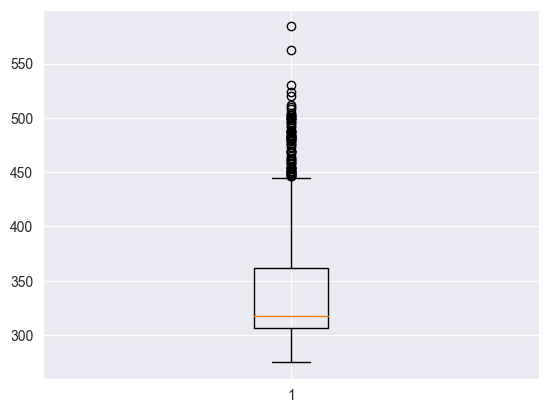

In [727]:
plt.boxplot(data["Удельный расход условного топлива на отпуск э/э гр.130"]);

In [728]:
data = data.loc[data[target] < 507]
data = data.loc[data[target] > 100]

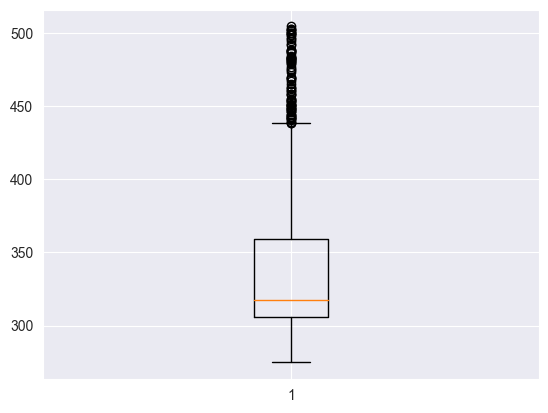

In [729]:
plt.boxplot(data[target]);

In [730]:
X = data.drop(target, axis=1)

In [731]:
scaler = StandardScaler()

In [732]:
y = data[target]

In [733]:
input_shape = X.shape[1]

In [1059]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_shape, 15)
        self.fc2 = nn.Linear(15, 15)
        self.fc3 = nn.Linear(15, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

In [1060]:
def predict(_model, prediction_data):
    _model.eval()
    if isinstance(prediction_data, list):
        Y_pred = [_model(X_batch.double()) for X_batch in prediction_data]
    else:
        Y_pred = [_model(X_batch) for X_batch, _ in prediction_data]
    return Y_pred

In [1061]:
def score_model(_model, metric, prediction_data):
    _model.eval()
    scores = 0
    for X_batch, Y_label in prediction_data:
        Y_pred = _model(X_batch)
        scores += metric(
            Y_label.detach().numpy(), Y_pred.detach().numpy()
        ).mean().item()

    return scores / len(prediction_data)

In [1068]:
def train(_model, opt, loss_function, epochs, data_tr, data_val, scoring=r2_score):
    loses = []
    scores = {
        "train": [],
        "val": []
    }
    scheduler = torch.optim.lr_scheduler.StepLR(opt, 30)
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        _model.train()
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            opt.zero_grad()
            Y_pred = _model(X_batch)
            model_loss = loss_function(Y_batch, Y_pred)
            model_loss.backward()
            opt.step()

            avg_loss += model_loss / len(data_tr)
        scheduler.step()
        toc = time()

        _model.eval()
        val_score = score_model(_model, scoring, data_val)
        train_score =  score_model(_model, scoring, data_tr)
        scores["val"].append(
            0 if val_score < 0 else val_score
        )
        scores["train"].append(
            0 if train_score < 0 else train_score
        )
        clear_output(wait=True)
        clear_output(wait=True)
        plt.plot(scores["val"], label="val")
        plt.plot(scores["train"], label="train")
        plt.legend(title="type")
        plt.show()
        print('loss:', avg_loss, toc - tic)
        loses.append(float(avg_loss.detach()))
    return loses, scores

In [1072]:
X_train, X_test, y_train, y_test = train_test_split(
    X.to_numpy(), y.to_numpy(), test_size=0.05, random_state=42
)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)

train_loader = DataLoader(list(zip(X_train, y_train)), shuffle=True, batch_size=16)
val_loader = DataLoader(list(zip(X_test, y_test)), shuffle=True, batch_size=16)

In [1073]:
model = SimpleNN()
loss_fn = nn.MSELoss()
optim = torch.optim.AdamW(model.parameters(), 0.05)

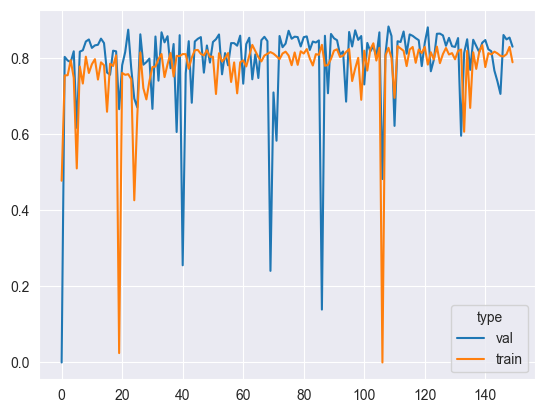

loss: tensor(388.4659, grad_fn=<AddBackward0>) 0.022061824798583984


In [1074]:
loss, score = train(model, optim, loss_fn, 150, train_loader, val_loader)

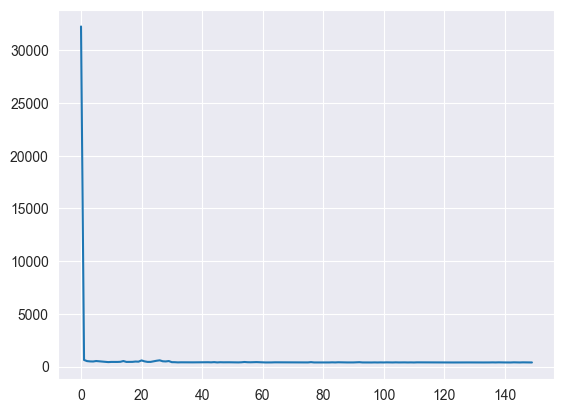

In [1075]:
plt.plot(loss);

In [1076]:
test_loader = DataLoader(list(zip(X_test, y_test)))

predictions = predict(model, test_loader)
predictions = list(map(lambda x: x.detach().numpy(), predictions))

In [1077]:
predictions = list(map(lambda x: x.reshape(-1).tolist(), predictions))

In [1078]:
predictions = np.array(list(chain.from_iterable(predictions)))

In [1079]:
predictions = convert(predictions)

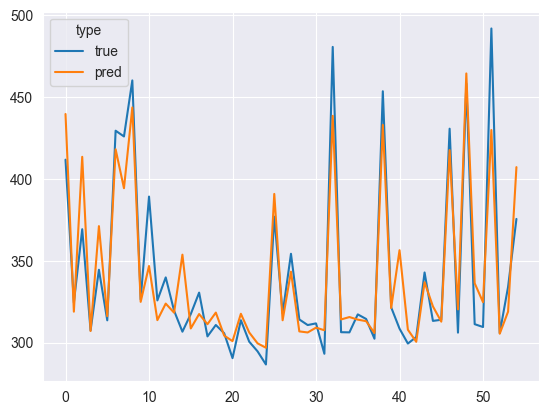

In [1080]:
plt.plot(y_test, label="true")
plt.plot(predictions, label="pred")
plt.legend(title="type");

In [1081]:
r2_score(y_test, predictions)

0.8606035225064179

In [1082]:
X_for_test = torch.tensor(scaler.transform(X.to_numpy()), dtype=torch.float32)
y_for_test = torch.tensor(y.to_numpy(), dtype=torch.float32).reshape(-1, 1)

In [1083]:
test_loader = DataLoader(list(zip(X_for_test, y_for_test)))

predictions = predict(model, test_loader)
predictions = list(map(lambda x: x.detach().numpy(), predictions))

In [1084]:
predictions = list(map(lambda x: x.reshape(-1).tolist(), predictions))

In [1085]:
predictions = np.array(list(chain.from_iterable(predictions)))

In [1086]:
predictions = convert(predictions)

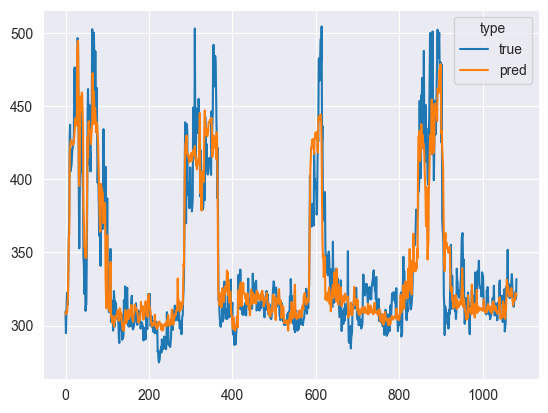

In [1087]:
plt.plot(y_for_test, label="true")
plt.plot(predictions, label="pred")
plt.legend(title="type");

In [1088]:
predictions.shape

(1082,)

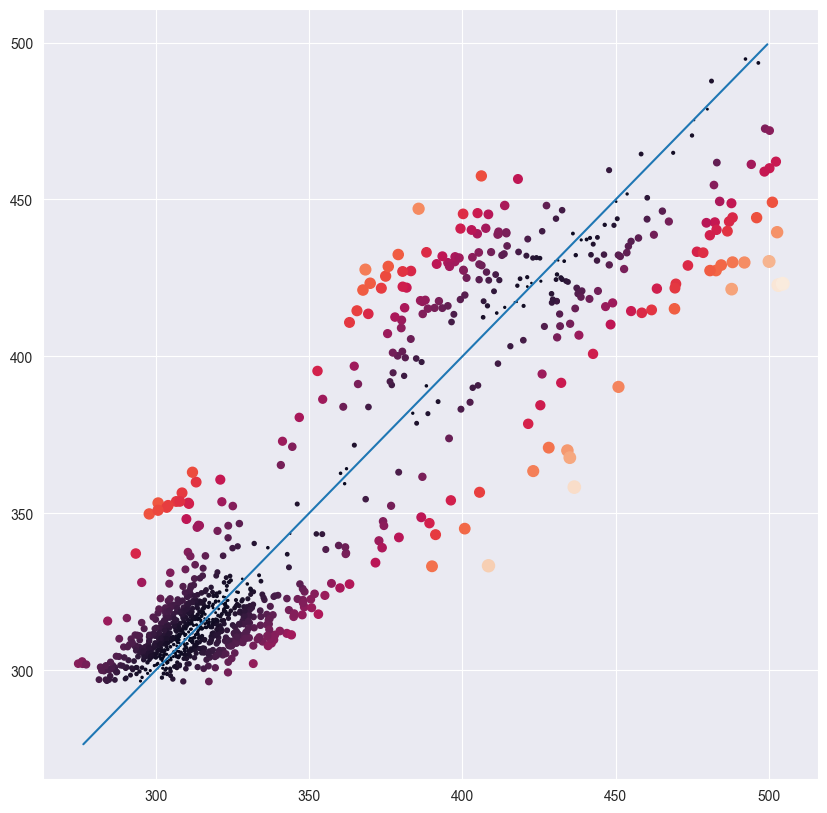

In [1089]:
y_for_test = y_for_test.numpy()
predictions = predictions.reshape(-1, 1)
area = abs(y_for_test - predictions)
plt.figure(figsize=(10, 10))
plt.plot(
    np.arange(min(predictions) - 20, max(predictions) + 5),
    np.arange(min(predictions) - 20, max(predictions) + 5)
)
plt.scatter(y_for_test, predictions, marker='o', s=area, c=area);

In [1090]:
import pickle

In [1092]:
with open("models/nn_fuelTA130_086.bf", "wb") as file:
    pickle.dump(model, file)

In [1093]:
with open("models/nn_fuelTA130_086_scaler.bf", "wb") as file:
    pickle.dump(scaler, file)